#Neural Style Transfer (NST) using the pre-trained VGG model

Welcome to the **Neural Transfer Notebook**! In this notebook, I delve into the fascinating world of neural style transfer, a technique that leverages deep learning to blend the content of one image with the artistic style of another. By utilizing a pre-trained VGG19 model, I aim to transform my paintings into unique artworks that reflect the essence of both the original content and the chosen style. This process not only showcases the capabilities of artificial intelligence in the realm of art but also serves as a platform for experimentation and creativity. Join me as I explore the intricacies of this technique and share the results of my artistic endeavors.



In [1]:
#!pip install torchvision

In [1]:
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
from google.colab import files
import shutil

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Upload files
uploaded = files.upload()

# Step 3: Move uploaded files to Google Drive
for filename in uploaded.keys():
    # Specify the destination path in your Google Drive
    destination_path = f'/content/drive/My Drive/{filename}'
    # Move the uploaded file to Google Drive
    shutil.move(filename, destination_path)
    print(f'Moved {filename} to {destination_path}')


Mounted at /content/drive


Saving painting1.png to painting1.png
Saving painting2.png to painting2.png
Moved painting1.png to /content/drive/My Drive/painting1.png
Moved painting2.png to /content/drive/My Drive/painting2.png


In [3]:
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert('RGB') # Convert the image to RGB

    # If the image is larger than the maximum size, resize it
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    # Preprocess the image from (h, w, 3) array to a (3, h, w) tensor & normalizes pixels
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0) #adds an extra batch dim - PyTorch expects images passed thru models as batches
    return image

In [15]:
import torch
from torchvision import transforms
from PIL import Image

# Function to load and preprocess the images
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize to a fixed size
        transforms.ToTensor(),           # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Load images from Google Drive path
content_image_path = '/content/drive/My Drive/painting1.png'  # Adjust the filename if necessary
style_image_path = '/content/drive/My Drive/painting2.png'    # Adjust the filename if necessary

# Load and preprocess the images using your existing function
content_image = load_image(content_image_path)
style_image = load_image(style_image_path)


In [16]:
# Function to display images
def imshow(tensor, title=None):
    tensor = tensor.cpu().clone()  # Clone tensor to avoid changing the original
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = transforms.ToPILImage()(tensor)  # Convert to PIL image
    plt.imshow(tensor)
    if title:
        plt.title(title)
    plt.show()

In [17]:
# Define the VGG19 model (pre-trained) for style transfer
vgg = models.vgg19(pretrained=True).features.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 70.9MB/s]


Step 0, Loss 0.002547126030549407
Step 50, Loss 2.4213204383850098
Step 100, Loss 0.618432343006134
Step 150, Loss 0.4706631600856781
Step 200, Loss 0.49927690625190735
Step 250, Loss 0.5649745464324951


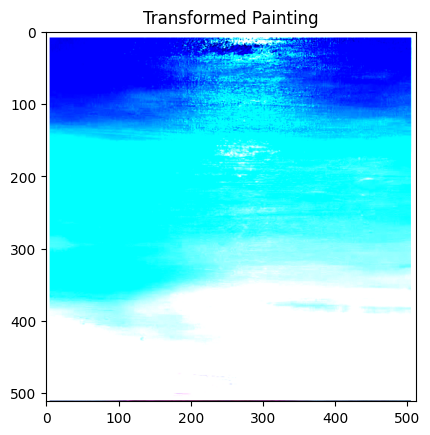

In [18]:
# Check if CUDA is available (use GPU for faster computation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_image = content_image.to(device)
style_image = style_image.to(device)
vgg = vgg.to(device)

# Extract features from specific layers
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # content layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram matrix function (used for style loss)
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

# Compute the loss function (content + style)
def compute_loss(content_features, style_features, target_features):
    content_weight = 1e4
    style_weight = 1e2

    # Content loss (difference between content image and target)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss (difference between style image and target)
    style_loss = 0
    for layer in style_features:
        gram_target = gram_matrix(target_features[layer])
        gram_style = gram_matrix(style_features[layer])
        style_loss += torch.mean((gram_target - gram_style)**2)

    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Create a copy of the content image to optimize
target_image = content_image.clone().requires_grad_(True).to(device)

# Define optimizer
optimizer = optim.Adam([target_image], lr=0.003)

# Run the style transfer for a set number of iterations
num_steps = 300
for step in range(num_steps):
    optimizer.zero_grad()

    # Extract features
    target_features = get_features(target_image, vgg)
    content_features = get_features(content_image, vgg)
    style_features = get_features(style_image, vgg)

    # Compute the loss
    loss = compute_loss(content_features, style_features, target_features)
    loss.backward()

    optimizer.step()

    # Print progress every 50 steps
    if step % 50 == 0:
        print(f"Step {step}, Loss {loss.item()}")

# Convert the final image to a displayable format and show it
final_img = target_image.squeeze().cpu().detach()
final_img = final_img.clamp(0, 1)
imshow(final_img, title="Transformed Painting")



### Conclusion

In this notebook, I experimented with two paintings using techniques like neural style transfer to push the boundaries of creativity and blend technology with art. As I continue to create and share my AI-generated artworks, I hope to inspire others to embrace the exciting possibilities that arise at the intersection of art and technology. Stay tuned for future updates, and let’s continue to explore the creative potential of AI together!
